<a href="https://colab.research.google.com/github/HJapok/Palmoil_HDE_Estimate/blob/master/Harvest_Estimation_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import os
import pandas as pd
  
# Get the list of all files and directories
# in the root directory
path = "/content/drive/MyDrive/segmented_data"
dir_list = os.listdir(path)
data_arr = []
for i in dir_list:
    img_fol=os.path.join(path, str(i))
    img_list = os.listdir(img_fol)
    for k in img_list:
        data={
            'Filepath':os.path.join(img_fol, str(k)),
            'Day':int(str(k).split('_')[2])
                }
        data_arr.append(data)


image_df = pd.DataFrame(data_arr, 
             columns=['Filepath', 
                      'Day'])
print(image_df.head(5))
        

                                            Filepath  Day
0  /content/drive/MyDrive/segmented_data/unripe/u...   52
1  /content/drive/MyDrive/segmented_data/unripe/u...   52
2  /content/drive/MyDrive/segmented_data/unripe/u...   52
3  /content/drive/MyDrive/segmented_data/unripe/u...   52
4  /content/drive/MyDrive/segmented_data/unripe/u...   52


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_df

,Filepath,Day
5838,/content/drive/MyDrive/segmented_data/underrip...,92
9406,/content/drive/MyDrive/segmented_data/underrip...,68
15007,/content/drive/MyDrive/segmented_data/overripe...,141
280,/content/drive/MyDrive/segmented_data/unripe/u...,54
5625,/content/drive/MyDrive/segmented_data/underrip...,90
...,...,...
905,/content/drive/MyDrive/segmented_data/unripe/u...,9
5192,/content/drive/MyDrive/segmented_data/unripe/u...,11
12172,/content/drive/MyDrive/segmented_data/ripe/rip...,140
235,/content/drive/MyDrive/segmented_data/unripe/u...,54


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Day',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=False
)

Found 8624 validated image filenames.
Found 2156 validated image filenames.
Found 4620 validated image filenames.


In [ ]:
# N_mobile = tf.keras.applications.mobilenet_v2.MobileNetV2( input_tensor = tf.keras.Input(
#     shape=(224, 224, 3)), 
#     include_top=False, 
#     weights='imagenet'
#     )

N_mobile = tf.keras.applications.mobilenet_v2.MobileNetV2( 
    include_top=False, 
    weights='imagenet'
    )

N_mobile.trainable = True
base_model_output = N_mobile.output
flattened_output = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
class_prediction = tf.keras.layers.Dense(256, activation="relu")(flattened_output)
class_prediction = tf.keras.layers.Dense(128, activation="relu")(class_prediction)
class_prediction = tf.keras.layers.Dense(64, activation="relu")(class_prediction)
class_prediction = tf.keras.layers.Dense(1, activation='linear')(class_prediction)
model = tf.keras.models.Model(inputs=N_mobile.input, outputs=  class_prediction)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200),
    loss='mse',
    metrics=['mse', 'mae']
)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                               

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                32)                               'block_4_project_BN[0][0]']     
                                                                                                  
 block_5_expand (Conv2D)        (None, None, None,   6144        ['block_4_add[0][0]']            
                                192)                                                              
                                                                                                  
 block_5_expand_BN (BatchNormal  (None, None, None,   768        ['block_5_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_5_expand_relu (ReLU)     (None, None, None,   0           ['block_5_expand_BN[0][0]']      
                                192)                                                              
          

In [ ]:
rm -rf '/content/checkpoint'

In [ ]:
import os
checkpoint_filepath = '/content/checkpoint'
if not os.path.exists(checkpoint_filepath):
   os.makedirs(checkpoint_filepath)

filepath=os.path.join(checkpoint_filepath,"weights-epoch-{epoch:02d}-valmse-{val_mse:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_mse',
            patience=100,
            restore_best_weights=True
        )

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=70,
    verbose=1,
    callbacks=[model_checkpoint_callback,early_stopping]
)

Epoch 1/70
1078/1078 [==============================] - 5424s 5s/step - loss: 137.6532 - mse: 137.6532 - mae: 6.9555 - val_loss: 3625.2917 - val_mse: 3625.2917 - val_mae: 54.3905
Epoch 2/70
1078/1078 [==============================] - 80s 74ms/step - loss: 27.0018 - mse: 27.0018 - mae: 3.7243 - val_loss: 1482.6417 - val_mse: 1482.6417 - val_mae: 35.4472
Epoch 3/70
1078/1078 [==============================] - 80s 74ms/step - loss: 10.0966 - mse: 10.0966 - mae: 2.4263 - val_loss: 308.6322 - val_mse: 308.6322 - val_mae: 16.7882
Epoch 4/70
1078/1078 [==============================] - 80s 74ms/step - loss: 17.5162 - mse: 17.5162 - mae: 3.0042 - val_loss: 8881.5850 - val_mse: 8881.5850 - val_mae: 91.1923
Epoch 5/70
1078/1078 [==============================] - 79s 74ms/step - loss: 12.0019 - mse: 12.0019 - mae: 2.4844 - val_loss: 196.6185 - val_mse: 196.6185 - val_mae: 13.1283
Epoch 6/70
1078/1078 [==============================] - 80s 74ms/step - loss: 5.9572 - mse: 5.9572 - mae: 1.8707 - va

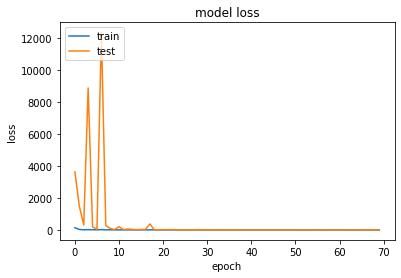

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

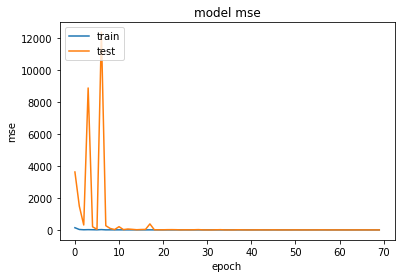

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import os
model_filepath = '/content/drive/MyDrive/Model_MobileNetV2'
if not os.path.exists(model_filepath):
   os.makedirs(model_filepath)

# Save model in json and model weight by h5 
model_json = model.to_json()
with open(os.path.join(model_filepath,"model5.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join(model_filepath,"model.h5"))
print("Saved model to disk")

Saved model to disk


In [ ]:
# load new model in json format
model_filepath = '/content/drive/MyDrive/Model_MobileNetV2'
json_file = open(os.path.join(model_filepath,"model5.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Model_MobileNetV2/weights-improvement-28-0.27.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 200),
    loss='mse',
    metrics=['mse', 'mae']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Retraining
import os
checkpoint_filepath = '/content/checkpoint'
if not os.path.exists(checkpoint_filepath):
   os.makedirs(checkpoint_filepath)

filepath=os.path.join(checkpoint_filepath,"weights-improvement-{epoch:02d}-{val_mse:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_mse',
            patience=100,
            restore_best_weights=True
        )

history = loaded_model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    verbose=1,
    callbacks=[model_checkpoint_callback,early_stopping]
)

Epoch 1/30
1078/1078 [==============================] - 86s 75ms/step - loss: 1.0641 - mse: 1.0641 - mae: 0.7253 - val_loss: 2.8056 - val_mse: 2.8056 - val_mae: 1.4572
Epoch 2/30
1078/1078 [==============================] - 81s 75ms/step - loss: 0.5997 - mse: 0.5997 - mae: 0.6059 - val_loss: 0.5202 - val_mse: 0.5202 - val_mae: 0.5733
Epoch 3/30
1078/1078 [==============================] - 80s 74ms/step - loss: 0.6978 - mse: 0.6978 - mae: 0.6456 - val_loss: 1.9143 - val_mse: 1.9143 - val_mae: 1.2817
Epoch 4/30
1078/1078 [==============================] - 81s 75ms/step - loss: 0.5831 - mse: 0.5831 - mae: 0.5903 - val_loss: 1.1381 - val_mse: 1.1381 - val_mae: 0.9059
Epoch 5/30
1078/1078 [==============================] - 80s 74ms/step - loss: 0.7350 - mse: 0.7350 - mae: 0.6566 - val_loss: 1.5787 - val_mse: 1.5787 - val_mae: 1.0400
Epoch 6/30
1078/1078 [==============================] - 81s 75ms/step - loss: 0.7848 - mse: 0.7848 - mae: 0.6871 - val_loss: 0.7429 - val_mse: 0.7429 - val_mae:

In [ ]:
# Retrain and resave
# Save model in json and model weight by h5 
model_json = loaded_model.to_json()
with open("/content/drive/MyDrive/model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights(os.path.join(model_filepath,"model.h5"))
print("Saved model to disk")

Saved model to disk


In [ ]:
# Direct save model together with model and ist weight
loaded_model.save('/content/drive/MyDrive/model_2.h5')

In [ ]:
# Load the model
modeling = tf.keras.models.load_model('/content/checkpoint/weights-improvement-46-0.39.hdf5')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predicted_ages = np.squeeze(loaded_model.predict(test_images))
true_ages = test_images.labels

rmse = mean_squared_error(true_ages, predicted_ages)
print("rmse: ", rmse)

r2 = r2_score(true_ages, predicted_ages)
print("r2: ",r2)

285/578 [=============>................] - ETA: 6:59

In [ ]:
from PIL import Image
image_path = "/content/drive/MyDrive/segmented_data/ripe/ripe_day_115_pic_10.png"
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = tf.image.resize(input_arr,(224,224))
input_arr = np.array([input_arr])
input_arr*1./255
input_arr=input_arr*1./255
input_arr
predictions = loaded_model.predict(input_arr)
print(np.squeeze(predictions))

print(round(float(np.squeeze(predictions))))

1/1 [==============================] - 0s 24ms/step
116.11013
116


In [ ]:
import tensorflow as tf
import numpy as np
import os
from datetime import datetime
from datetime import timedelta
import cv2

image_path ="/content/drive/MyDrive/segmented_data/unripe/unripe_day_46_pic_10.png"
image2 = cv2.imread(image_path)
image =image2[...,::-1] # reverse the channels
input_arr2 = tf.keras.preprocessing.image.img_to_array(image)
input_arr2 = tf.image.resize(input_arr2,(224,224))
input_arr = np.array([input_arr2])
input_arr*1./255
input_arr=input_arr*1./255
input_arr
predictions = loaded_model.predict(input_arr)
print(np.squeeze(predictions))
print(round(float(np.squeeze(predictions))))

median_ripe_day = 127
overripe_day = 141
predicted_day = round(float(np.squeeze(predictions)))
day_b4_ripe = median_ripe_day - predicted_day
day_to_overripe = overripe_day - predicted_day
harvest_date = (datetime.now() + timedelta(days=day_b4_ripe) ).strftime('%Y-%m-%d')
harvest_before = (datetime.now() + timedelta(days=day_to_overripe) ).strftime('%Y-%m-%d')
print("best_harvest_date :", harvest_date)
print("harvest_before :", harvest_before)

1/1 [==============================] - 0s 19ms/step
45.956448
46
best_harvest_date : 2023-01-08
harvest_before : 2023-01-22
